## BE Data Science : Identification des utilisateurs de Copilote

### Introduction
Dans ce notebook, nous allons analyser les traces d’utilisation du logiciel Copilote afin d’identifier les utilisateurs à partir de leurs actions.
Nous commencerons par explorer et nettoyer les données, puis nous construirons des caractéristiques pertinentes pour la classification. Enfin, nous entraînerons plusieurs modèles (Random Forest, XGBoost, MLP et LSTM) pour prédire l’utilisateur et évaluer leurs performances.

L’objectif est de produire une chaîne complète allant du prétraitement des données à la prédiction finale

In [61]:
pip install seaborn pandas xgboost tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 MB 26.1 MB/s  0:00:09m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 47.7 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 57.6 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 52.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 49.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 36.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 39.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 60.9 MB/s  0:00:00m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 15.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.4/622.4 kB 26.6 MB/s  0:00:00
  Attempting uninstall: numpy╸━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10/32 [opt-einsum]-data-server]stem]
    Found existing installation: numpy 2.2.6━━━━━━━━━━━━━━━━━━ 10/32 [opt-einsum]
    Uninstalling nu

### Chargement des données brutes en mémoire


In [31]:
import pandas as pd
import csv

def read_ds(ds_name: str):
    rows = []
    
    with open(ds_name, "r", encoding="utf-8") as f:
        lines = f.readlines()
    
    sample_line = lines[0]
    sniffer = csv.Sniffer()
    try:
        dialect = sniffer.sniff(sample_line)
        delim = dialect.delimiter
    except csv.Error:
        delim = ","   
    
    for line in lines:
        line = line.strip()
        if not line:
            continue  
        
        parts = line.split(delim)
        rows.append(parts)
    

    max_len = max(len(r) for r in rows)
    
   
    columns = ["util", "navigateur"] + [f"action_{i}" for i in range(1, max_len - 1)]

    normalized_rows = [r + [None]*(max_len - len(r)) for r in rows]
    
    df = pd.DataFrame(normalized_rows, columns=columns)
    return df



In [32]:
features_train = read_ds("train.csv")
features_test = read_ds("test.csv")
features_train.shape, features_test.shape

((3279, 14470), (324, 7726))

In [33]:
features_train.head()

,util,navigateur,action_1,action_2,action_3,action_4,action_5,action_6,action_7,action_8,...,action_14459,action_14460,action_14461,action_14462,action_14463,action_14464,action_14465,action_14466,action_14467,action_14468
0,nuh,Firefox,Création d'un écran(infologic.core.accueil.Acc...,Affichage d'une dialogue,Exécution d'un bouton,Fermeture d'une dialogue,Affichage d'une dialogue,Exécution d'un bouton,Fermeture d'une dialogue,Création d'un écran(infologic.core.gui.control...,...,None,None,None,None,None,None,None,None,None,None
1,muz,Google Chrome,Création d'un écran(infologic.core.gui.control...,Création d'un écran(infologic.core.gui.control...,t5,Sélection d’un onglet(infologic.orga.modules.O...,t10,Exécution d'un bouton,t15,Sélection d’un onglet,...,None,None,None,None,None,None,None,None,None,None
2,zrx,Microsoft Edge,Affichage d'une dialogue(infologic.core.gui.co...,Exécution d'un bouton,Chainage,Fermeture d'une dialogue,Affichage d'une dialogue(infologic.acti.module...,Clic sur une grille d'historique de recherche,Raccourci,Fermeture d'une dialogue,...,None,None,None,None,None,None,None,None,None,None
3,pou,Firefox,Création d'un écran(infologic.core.gui.control...,t5,Exécution d'un bouton(MAINT),Affichage d'une dialogue,Fermeture d'une dialogue,Double-clic,Exécution d'un bouton,Lancement d'une stat(infologic.core.gui.contro...,...,None,None,None,None,None,None,None,None,None,None
4,ald,Google Chrome,Affichage d'une dialogue(infologic.acti.module...,t5,Exécution d'un bouton,Fermeture d'une dialogue,t10,Entrée en saisie dans un formulaire,t10,Affichage d'une dialogue,...,None,None,None,None,None,None,None,None,None,None


### Première analyse de ces données

In [34]:
features_train.iloc[:, :20].head()

,util,navigateur,action_1,action_2,action_3,action_4,action_5,action_6,action_7,action_8,action_9,action_10,action_11,action_12,action_13,action_14,action_15,action_16,action_17,action_18
0,nuh,Firefox,Création d'un écran(infologic.core.accueil.Acc...,Affichage d'une dialogue,Exécution d'un bouton,Fermeture d'une dialogue,Affichage d'une dialogue,Exécution d'un bouton,Fermeture d'une dialogue,Création d'un écran(infologic.core.gui.control...,t5,Exécution d'un bouton(MAINT),Affichage d'une dialogue,Fermeture d'une dialogue,Double-clic,Exécution d'un bouton,Lancement d'une stat(infologic.core.gui.contro...,Affichage d'un toast,Lancement d'une stat(infologic.core.gui.contro...,t10
1,muz,Google Chrome,Création d'un écran(infologic.core.gui.control...,Création d'un écran(infologic.core.gui.control...,t5,Sélection d’un onglet(infologic.orga.modules.O...,t10,Exécution d'un bouton,t15,Sélection d’un onglet,Exécution d'un bouton,Chainage,t20,Sélection d’un onglet(MAJ),t25,Sélection d'un écran(infologic.orga.modules.OR...,Sélection d'un écran,Exécution d'un bouton,Chainage,t30
2,zrx,Microsoft Edge,Affichage d'une dialogue(infologic.core.gui.co...,Exécution d'un bouton,Chainage,Fermeture d'une dialogue,Affichage d'une dialogue(infologic.acti.module...,Clic sur une grille d'historique de recherche,Raccourci,Fermeture d'une dialogue,Création d'un écran,t5,Clic sur une grille d'historique de recherche,Raccourci,Exécution d'un bouton,Affichage d'une dialogue,t10,Clic sur une grille d'historique de recherche,Raccourci,Exécution d'un bouton
3,pou,Firefox,Création d'un écran(infologic.core.gui.control...,t5,Exécution d'un bouton(MAINT),Affichage d'une dialogue,Fermeture d'une dialogue,Double-clic,Exécution d'un bouton,Lancement d'une stat(infologic.core.gui.contro...,t10,Filtrage / Tri(MAINT),Clic sur une grille d'historique de recherche,Sélection d'un flag,Filtrage / Tri,t15,Affichage d'une dialogue,Clic sur une grille d'historique de recherche,Affichage d'une dialogue,t20
4,ald,Google Chrome,Affichage d'une dialogue(infologic.acti.module...,t5,Exécution d'un bouton,Fermeture d'une dialogue,t10,Entrée en saisie dans un formulaire,t10,Affichage d'une dialogue,t15,Fermeture d'une dialogue,t20,Sélection d'un écran(infologic.crm.modules.CRM...,Exécution d'un bouton,Action de table,Affichage d'un toast,Affichage d'une dialogue,Affichage d'une dialogue,Exécution d'un bouton


In [35]:
number_unique_navigators = list(features_train['navigateur'].value_counts())
print(len(number_unique_navigators))

4


Définissons maintenant les fonctions dont nous aurons besoin plus tard pour afficher les graphes:

In [36]:
import warnings
from IPython.display import display, Markdown

# décorateurs utilitaires pour supprimer les avertissements de la sortie et imprimer un cadre de données dans un tableau Markdown.
def ignore_warnings(f):
    def _f(*args, **kwargs):
        warnings.filterwarnings('ignore')
        v = f(*args, **kwargs)
        warnings.filterwarnings('default')
        return v
    return _f

# affiche un DataFrame Pandas sous forme de tableau Markdown dans un notebook Jupyter.
def markdown_table(headNtail=False, use_index=True, title=None, precision=2):
    def _get_value(val): return str(round(val, precision) if isinstance(val, float) else val)
    def _format_row(row): 
        row_str = ""
        if use_index: row_str += f"|{str(row.name)}"
        for value in row.values: row_str += f"| {_get_value(value)}"
        return row_str + "|"
    def _get_str(df):
        return "\n".join(df.apply(_format_row, axis=1))
    def _deco(f):
        def _f(*args, **kwargs):
            df = f(*args, **kwargs)
            _str = f"#### {title}\n" if title else ""
            header = ([str(df.index.name)] if use_index else []) + df.columns.astype(str).to_list() 
            _str += f"|{'|'.join(header)}|" + f"\n|{'--|'*len(header)}\n" if header else None
            if headNtail:
                _str += _get_str(df.head())
                _str += "\n|...|...|\n"
                _str += _get_str(df.tail())
            else:
                _str += _get_str(df)
            display(Markdown(_str))
        return _f
    return _deco

# fonction utilitaire permettant d'obtenir une grille graphique à partir d'un nombre arbitraire de lignes/colonnes ou de données.
def get_grid(n, n_row=None, n_col=None, titles=None, figsize=(10, 8), wspace=.5, hspace=.5, **kwargs):
    if n_row: n_col= n_col or math.floor(n/n_row)
    elif n_col: n_row= n_row or math.ceil(n/n_col)
    else:
        n_row = math.ceil(math.sqrt(n))
        n_col = math.floor(n/n_row)
    fig, axs = plt.subplots(n_row, n_col, figsize=figsize, **kwargs)
    plt.subplots_adjust(hspace=hspace, wspace=wspace)
    if titles is not None:
        for ax, title in zip(axs.flat, titles): ax.set_title(title)
    return fig, axs

In [37]:
features_train["util"]


0       nuh
1       muz
2       zrx
3       pou
4       ald
       ... 
3274    muz
3275    cjr
3276    fuz
3277    cjr
3278    fwf
Name: util, Length: 3279, dtype: object

In [38]:
user_nav_grouped = features_train.groupby("util")["navigateur"].apply(list)
print(user_nav_grouped)

util
aho    [Google Chrome, Google Chrome, Google Chrome, ...
ajo    [Firefox, Firefox, Firefox, Firefox, Firefox, ...
akx    [Google Chrome, Google Chrome, Google Chrome, ...
ald    [Google Chrome, Google Chrome, Google Chrome, ...
ats    [Firefox, Firefox, Firefox, Firefox, Firefox, ...
                             ...                        
zqs    [Microsoft Edge, Microsoft Edge, Microsoft Edg...
zro    [Firefox, Firefox, Firefox, Firefox, Firefox, ...
zrx    [Microsoft Edge, Microsoft Edge, Microsoft Edg...
zus    [Firefox, Firefox, Firefox, Firefox, Firefox, ...
zyk    [Google Chrome, Google Chrome, Google Chrome, ...
Name: navigateur, Length: 247, dtype: object


In [39]:
@markdown_table(title="Navigateur par utilisateur", headNtail=True)
def browsers_per_player(df):
    user_nav_grouped = df.groupby("util")["navigateur"].apply(list).reset_index()
    return user_nav_grouped

browser_user_df = browsers_per_player(features_train)



#### Navigateur par utilisateur
|None|util|navigateur|
|--|--|--|
|0| aho| ['Google Chrome', 'Google Chrome', 'Google Chrome', 'Google Chrome', 'Google Chrome', 'Google Chrome', 'Google Chrome', 'Google Chrome', 'Google Chrome', 'Google Chrome']|
|1| ajo| ['Firefox', 'Firefox', 'Firefox', 'Firefox', 'Firefox', 'Firefox', 'Firefox', 'Firefox', 'Firefox', 'Firefox', 'Firefox', 'Firefox', 'Firefox']|
|2| akx| ['Google Chrome', 'Google Chrome', 'Google Chrome', 'Google Chrome', 'Google Chrome', 'Google Chrome', 'Google Chrome', 'Google Chrome', 'Google Chrome', 'Google Chrome', 'Google Chrome', 'Google Chrome', 'Google Chrome', 'Google Chrome']|
|3| ald| ['Google Chrome', 'Google Chrome', 'Google Chrome', 'Google Chrome', 'Google Chrome', 'Google Chrome', 'Google Chrome', 'Google Chrome', 'Google Chrome', 'Google Chrome', 'Google Chrome', 'Google Chrome', 'Google Chrome', 'Google Chrome', 'Google Chrome']|
|4| ats| ['Firefox', 'Firefox', 'Firefox', 'Firefox', 'Firefox', 'Firefox', 'Firefox', 'Firefox', 'Firefox', 'Firefox', 'Firefox', 'Firefox']|
|...|...|
|242| zqs| ['Microsoft Edge', 'Microsoft Edge', 'Microsoft Edge', 'Microsoft Edge', 'Microsoft Edge', 'Microsoft Edge', 'Microsoft Edge', 'Microsoft Edge', 'Microsoft Edge', 'Microsoft Edge', 'Microsoft Edge', 'Microsoft Edge', 'Microsoft Edge', 'Microsoft Edge', 'Microsoft Edge', 'Microsoft Edge']|
|243| zro| ['Firefox', 'Firefox', 'Firefox', 'Firefox', 'Firefox', 'Firefox', 'Firefox', 'Firefox', 'Firefox', 'Firefox', 'Firefox', 'Firefox', 'Firefox']|
|244| zrx| ['Microsoft Edge', 'Microsoft Edge', 'Microsoft Edge', 'Microsoft Edge', 'Microsoft Edge', 'Microsoft Edge', 'Microsoft Edge', 'Microsoft Edge', 'Microsoft Edge', 'Microsoft Edge', 'Microsoft Edge', 'Microsoft Edge']|
|245| zus| ['Firefox', 'Firefox', 'Firefox', 'Firefox', 'Firefox', 'Firefox', 'Firefox', 'Firefox', 'Firefox', 'Firefox', 'Firefox', 'Firefox', 'Firefox']|
|246| zyk| ['Google Chrome', 'Google Chrome', 'Google Chrome', 'Google Chrome', 'Google Chrome', 'Google Chrome', 'Google Chrome', 'Google Chrome', 'Google Chrome', 'Google Chrome', 'Google Chrome', 'Google Chrome', 'Google Chrome', 'Google Chrome', 'Google Chrome', 'Google Chrome', 'Google Chrome', 'Google Chrome', 'Google Chrome', 'Google Chrome', 'Google Chrome']|

On observe que les utilisateurs utilisent toujours le même navigateur pour réaliser leurs actions. Regardons si certains utilisateurs utilisent plusieurs navigateurs:

In [40]:
user_nav_grouped = features_train.groupby("util")["navigateur"].apply(list).reset_index()


user_nav_grouped["unique_browsers_count"] = user_nav_grouped["navigateur"].apply(lambda x: len(set(x)))
filtered_users = user_nav_grouped[user_nav_grouped["unique_browsers_count"] > 1]


filtered_users = filtered_users[["util", "navigateur"]]

filtered_users.head()

,util,navigateur


Il n’y a absolument aucun utilisateur qui utilise plus d’un navigateur.
Les utilisateurs peuvent donc être classés en différentes catégories selon le navigateur qu’ils utilisent.
Si l’on relie ensuite cette information à leurs activités, on peut entraîner un modèle sur le jeu de données en utilisant ces caractéristiques.

In [41]:
@markdown_table(headNtail=True, title="Stats: Y distribution")
def get_Y_stats(df,key):
    y_counts = df[key].value_counts().reset_index()
    y_counts.columns = ["Y_value", "count"]
    return y_counts

get_Y_stats(features_train,"util")
get_Y_stats(features_train,"navigateur")

#### Stats: Y distribution
|None|Y_value|count|
|--|--|--|
|0| skm| 75|
|1| slq| 71|
|2| cjr| 46|
|3| flj| 42|
|4| hjs| 37|
|...|...|
|242| rff| 4|
|243| bez| 4|
|244| crn| 4|
|245| azn| 4|
|246| fyg| 4|

#### Stats: Y distribution
|None|Y_value|count|
|--|--|--|
|0| Firefox| 1466|
|1| Google Chrome| 1339|
|2| Microsoft Edge| 451|
|3| Opera| 23|
|...|...|
|0| Firefox| 1466|
|1| Google Chrome| 1339|
|2| Microsoft Edge| 451|
|3| Opera| 23|

Nous allons maintenant résumer dans un tableau l’ensemble des statistiques que nous pouvons extraire de notre jeu de données.
Par utilisateur et par navigateur, nous avons :

- nb_actions : nombre d’actions réalisées au cours d’une session utilisateur.
- temps_total : durée totale de la session utilisateur.
- vitesse : temps moyen par action.
- ecart_type_temps : variable utilisée pour compléter l’information sur la vitesse en analysant la variabilité du temps entre deux actions.
- taux_repetition : proportion d’actions consécutives identiques dans la session (on compare chaque action à la précédente ; si elles sont identiques, on incrémente un compteur, puis on divise ce score par le nombre total d’actions).
- longueur_moyenne_sequence : longueur moyenne des séquences d’actions identiques consécutives.
- diversite_actions : ratio entre le nombre d’actions uniques et le nombre total d’actions (mesure la variété du comportement).
- action_plus_frequente : type d’action le plus fréquemment observé dans la session.
- %_Affichage : pourcentage d’actions liées à « l’Affichage » (événements d’ouverture ou de visualisation).
- %_Exécution : pourcentage d’actions liées à « l’Exécution » (clics ou exécutions de boutons).
- %_Fermeture : pourcentage d’actions liées à « la Fermeture » (fermeture de fenêtres ou de dialogues).
- %_Création : pourcentage d’actions liées à « la Création » (création ou ouverture d’un nouvel écran).
- %_Autres : pourcentage d’actions ne figurant pas dans les catégories principales ci-dessus.



In [42]:
import pandas as pd
import re
from statistics import mean

def analyser_session_complete_row(row):
    utilisateur = row["util"]
    navigateur = row["navigateur"]
    actions = row.iloc[2:].dropna().tolist()

    current_time = 0
    timeline = []

    for elem in actions:
        match = re.match(r't(\d+)', str(elem).strip())
        if match:
            current_time = int(match.group(1))
        else:
            timeline.append((current_time, str(elem).strip()))

    df = pd.DataFrame(timeline, columns=["temps", "action"])
    if df.empty:
        return None

    # Nettoyage
    df["action_type"] = df["action"].apply(lambda x: x.split("(")[0].strip())

    # Statistiques de base
    nb_actions = len(df)
    temps_total = df["temps"].max() - df["temps"].min() if nb_actions > 1 else 0
    df["delta"] = df["temps"].diff().fillna(0)
    vitesse = temps_total / nb_actions if nb_actions > 1 else 0
    ecart_type_temps = df["delta"].std()

    # Répétitions et diversité
    diversite_actions = df["action_type"].nunique() / nb_actions
    action_plus_frequente = df["action_type"].value_counts().idxmax()
    df["repetition"] = (df["action_type"] == df["action_type"].shift(1)).astype(int)
    taux_repetition = df["repetition"].mean()

    # Séquences
    sequences = []
    current_seq = 1
    for i in range(1, len(df)):
        if df["action_type"].iloc[i] == df["action_type"].iloc[i - 1]:
            current_seq += 1
        else:
            sequences.append(current_seq)
            current_seq = 1
    sequences.append(current_seq)
    longueur_moyenne_sequence = sum(sequences) / len(sequences) if sequences else 0

    # Fréquences
    def freq(motcle):
        return (df["action_type"].str.contains(motcle, case=False, regex=False)).mean()

    freq_affichage = freq("Affichage")
    freq_execution = freq("Exécution")
    freq_fermeture = freq("Fermeture")
    freq_creation = freq("Création")
    freq_autres = 1 - (freq_affichage + freq_execution + freq_fermeture + freq_creation)

    return {
        "utilisateur": utilisateur,
        "navigateur": navigateur,
        "nb_actions": nb_actions,
        "temps_total": temps_total,
        "vitesse": round(vitesse, 2),
        "ecart_type_temps": round(ecart_type_temps, 2),
        "taux_repetition": round(taux_repetition, 3),
        "longueur_moyenne_sequence": round(longueur_moyenne_sequence, 2),
        "diversite_actions": round(diversite_actions, 2),
        "action_plus_frequente": action_plus_frequente,
        "%_Affichage": round(freq_affichage, 2),
        "%_Exécution": round(freq_execution, 2),
        "%_Fermeture": round(freq_fermeture, 2),
        "%_Création": round(freq_creation, 2),
        "%_Autres": round(freq_autres, 2)
    }


In [43]:
results = []
for _, row in features_train.iterrows():
    stats = analyser_session_complete_row(row)
    if stats:
        results.append(stats)

df_stats = pd.DataFrame(results)

In [44]:
pd.options.display.float_format = '{:.2f}'.format
display(df_stats)

,utilisateur,navigateur,nb_actions,temps_total,vitesse,ecart_type_temps,taux_repetition,longueur_moyenne_sequence,diversite_actions,action_plus_frequente,%_Affichage,%_Exécution,%_Fermeture,%_Création,%_Autres
0,nuh,Firefox,2514,2905,1.16,2.11,0.06,1.06,0.02,Exécution d'un bouton,0.27,0.28,0.15,0.03,0.28
1,muz,Google Chrome,90,230,2.56,2.51,0.33,1.50,0.19,Exécution d'un bouton$DB$,0.03,0.37,0.02,0.03,0.54
2,zrx,Microsoft Edge,608,750,1.23,2.16,0.11,1.13,0.07,Exécution d'un bouton,0.07,0.20,0.06,0.06,0.61
3,pou,Firefox,886,1445,1.63,2.35,0.11,1.12,0.04,Exécution d'un bouton,0.05,0.31,0.05,0.02,0.56
4,ald,Google Chrome,173,275,1.59,2.34,0.24,1.31,0.13,Exécution d'un bouton,0.06,0.35,0.06,0.06,0.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3273,muz,Google Chrome,122,135,1.11,2.08,0.12,1.14,0.24,Exécution d'un bouton$DB$,0.08,0.25,0.07,0.04,0.57
3274,cjr,Google Chrome,439,730,1.66,2.36,0.26,1.35,0.07,Exécution d'un bouton,0.14,0.31,0.11,0.03,0.40
3275,fuz,Firefox,1457,1730,1.19,2.13,0.16,1.20,0.04,Raccourci,0.08,0.16,0.06,0.04,0.67
3276,cjr,Google Chrome,630,1150,1.83,2.41,0.27,1.36,0.06,Exécution d'un bouton,0.13,0.26,0.08,0.04,0.48


On peut ainsi observer que certaines features sont plus importantes et impactantes que d'autres. 

### Construction de caractéristiques

#### Traitements préliminaires

Voyons s’il existe des valeurs aberrantes dans notre jeu de données.
Pour cela, nous devons examiner la fréquence des différentes actions et supprimer celles qui apparaissent le moins souvent.

Nous commençons par examiner quelles sont les actions présentes dans le jeu de données, afin de vérifier s’il en existe qui sortent des actions « officielles » ou attendues. 

In [45]:
def get_action_counts(df):
    action_cols = [col for col in df.columns if col.startswith("action_")]
    all_actions = df[action_cols].values.ravel()
    all_actions_series = pd.Series(all_actions).dropna()
    action_counts = all_actions_series.value_counts()
    
    return action_counts

action_counts = get_action_counts(features_train)

action_counts_df = action_counts.reset_index()
action_counts_df.columns = ["action", "count"]
action_counts_df.head()



,action,count
0,Exécution d'un bouton,265323
1,Saisie dans un champ,127325
2,Lancement d'une action générique,115069
3,Fermeture d'une dialogue,90338
4,Exécution d'un bouton1,89331


In [46]:
action_counts_df.tail()

,action,count
9440,Sélection d'un écran<DEF_03/24>$MAJ$,1
9441,Filtrage / Tri(infologic.acti.modules.AT_ACTIV...,1
9442,Dissimulation d'une arborescence(infologic.cor...,1
9443,Exécution d'un bouton<Défaut>1,1
9444,Chainage(MAINT)$EDI$,1


In [47]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings("ignore")

In [48]:

from statistics import mean
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from itertools import tee, islice

pattern_ecran = re.compile(r"\((.*?)\)")
pattern_conf = re.compile(r"<(.*?)>")
pattern_chaine = re.compile(r"\$(.*?)\$")

def ngrams(lst, n):
    return zip(*(islice(lst, i, None) for i in range(n)))

def extract_features(row, top_action_set=None, top_bigram_set=None):
    feats = {}
    actions_raw = row.iloc[2:].dropna().tolist()
    actions = [a.split("(")[0].strip() if isinstance(a, str) else "" for a in actions_raw]

    feats["n_actions"] = len(actions)
    feats["n_unique_actions"] = len(set(actions))
    feats["repeat_ratio"] = 1 - feats["n_unique_actions"]/feats["n_actions"] if feats["n_actions"]>0 else 0
    feats["n_modif"] = sum(a.endswith("1") for a in actions_raw if isinstance(a, str))
    feats["modif_ratio"] = feats["n_modif"]/feats["n_actions"] if feats["n_actions"]>0 else 0

    t_marks = [int(a[1:]) for a in actions_raw if isinstance(a,str) and a.startswith("t") and a[1:].isdigit()]
    feats["t_count"] = len(t_marks)
    feats["max_time"] = max(t_marks) if t_marks else 0
    feats["avg_time_gap"] = mean([j-i for i,j in zip(t_marks[:-1], t_marks[1:])]) if len(t_marks)>1 else 0
    feats["tempo_density"] = feats["n_actions"] / (feats["max_time"]+1)

    ecrans = [m.group(1) for a in actions_raw for m in [pattern_ecran.search(a)] if m]
    confs = [m.group(1) for a in actions_raw for m in [pattern_conf.search(a)] if m]
    chaines = [m.group(1) for a in actions_raw for m in [pattern_chaine.search(a)] if m]

    feats["uniq_ecrans"] = len(set(ecrans))
    feats["uniq_confs"] = len(set(confs))
    feats["uniq_chaines"] = len(set(chaines))

    feats["top_screen"] = Counter(ecrans).most_common(1)[0][0] if ecrans else "None"
    feats["top_conf"] = Counter(confs).most_common(1)[0][0] if confs else "None"
    feats["top_chain"] = Counter(chaines).most_common(1)[0][0] if chaines else "None"

    action_counts = Counter(actions)
    if top_action_set:
        for act in top_action_set:
            feats[f"act_{act}"] = action_counts.get(act, 0)
    else:
        for act, cnt in action_counts.items():
            feats[f"act_{act}"] = cnt

    bigrams = ["_".join(bg) for bg in ngrams(actions,2)]
    bigram_counts = Counter(bigrams)
    if top_bigram_set:
        for bg in top_bigram_set:
            feats[f"bigram_{bg}"] = bigram_counts.get(bg,0)
    else:
        for bg, cnt in bigram_counts.items():
            feats[f"bigram_{bg}"] = cnt

    feats["navigateur"] = row["navigateur"]

    if "util" in row:
        feats["util"] = row["util"]

    return feats


all_actions = []
all_bigrams = []

for _, row in features_train.iterrows():
    acts_raw = [a.split("(")[0].strip() for a in row.iloc[2:].dropna().tolist() if isinstance(a,str)]
    all_actions.extend(acts_raw)
    all_bigrams.extend(["_".join(bg) for bg in ngrams(acts_raw,2)])

top_actions = [act for act,_ in Counter(all_actions).most_common(100)]  # top 100 actions
top_bigrams = [bg for bg,_ in Counter(all_bigrams).most_common(100)]  # top 100 bigrams



On a ici extrait les features qui nous semblent les plus importantes pour réaliser le random forest et le xgboost. Ainsi, vons environ 200 à 300 features au total.

In [49]:
train_features = pd.DataFrame([extract_features(r, top_actions, top_bigrams) for _, r in features_train.iterrows()])
test_features = pd.DataFrame([extract_features(r, top_actions, top_bigrams) for _, r in features_test.iterrows()])


In [50]:
train_features["util"] = pd.Categorical(train_features["util"])
y = train_features["util"].cat.codes
X = train_features.drop(columns=["util"])

X = pd.get_dummies(X, columns=["navigateur","top_screen","top_conf","top_chain"], dummy_na=True)
X_test = pd.get_dummies(test_features, columns=["navigateur","top_screen","top_conf","top_chain"], dummy_na=True)
X_test = X_test.reindex(columns=X.columns, fill_value=0)

num_cols = X.select_dtypes(include=['int64','float64']).columns
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

X = X.fillna(0)
X_test = X_test.fillna(0)


In [51]:

X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


# Modèle 1: Random Forest

In [52]:
clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)

acc = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred, average="macro")
print(f"Accuracy : {acc:.4f}")
print(f"Macro-F1 : {f1:.4f}")

Accuracy : 0.8079
Macro-F1 : 0.7492


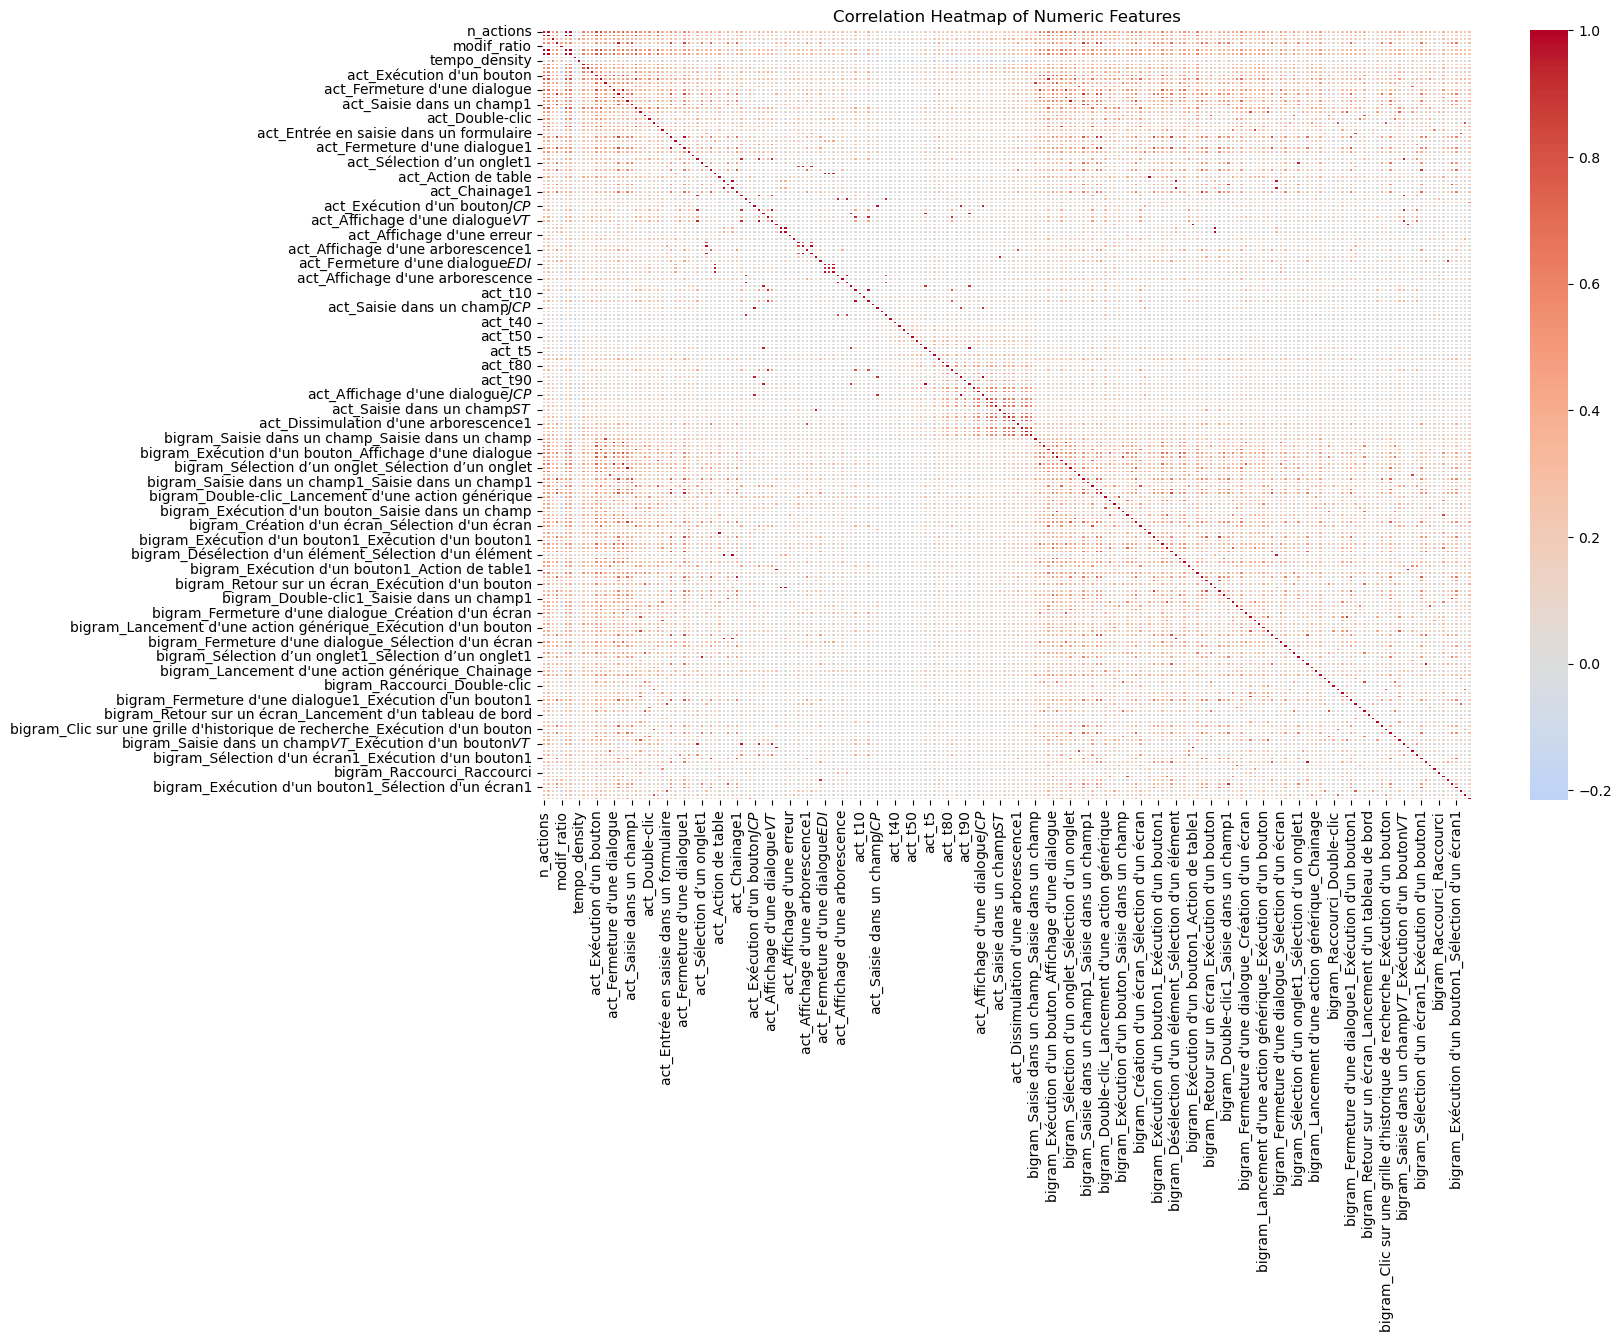

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns


corr = X[num_cols].corr()

plt.figure(figsize=(15, 10))
sns.heatmap(corr, cmap="coolwarm", center=0, linewidths=0.3)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

Cette heatmap nous confirme que les points sont majoritairement alignés il y a donc une corrélation visible entre certaines features. 

In [54]:
test_preds = clf.predict(X_test)
test_preds_labels = train_features["util"].cat.categories[test_preds]

In [55]:
submission_df_rf = pd.DataFrame({"prediction": test_preds_labels})
submission_df_rf.index.name = "RowId"
submission_df_rf.index += 1
submission_df_rf.to_csv("submission_rf.csv", index=True)
submission_df_rf.head()

,prediction
RowId,
1,hzx
2,prb
3,cxt
4,psg
5,cvw


Avec ce modèle "random forest" nous avons pu constater un f1 score de 75% ici et 68% sur la plateforme Kaggle. Le modèle est un algorithme qui se base sur des arbres de décisions indépendants. Cela va former des schémas qui vont donc favoriser la détection d'un comportement par rapport à un autre dans le cadre des utilisateurs.
Nous avons ensuite voulu tester un modèle XGB qui consiste également à créer des arbres de décisions mais qui est censé optimiser les erreurs par l'optimisation de la valeur du gradient.

# Modèle 2: XGB

In [56]:
xgb_model = XGBClassifier(
    n_estimators=800,
    learning_rate=0.03,
    max_depth=10,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=2,
    reg_alpha=1,
    random_state=42,
    tree_method="hist",
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)
y_val_pred = xgb_model.predict(X_val)

print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Validation F1 (macro):", f1_score(y_val, y_val_pred, average='macro'))
print(classification_report(y_val, y_val_pred))

Validation Accuracy: 0.7713414634146342
Validation F1 (macro): 0.6892965716645539
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.50      0.33      0.40         3
           2       0.50      0.67      0.57         3
           3       1.00      0.33      0.50         3
           4       0.50      1.00      0.67         2
           5       0.67      0.67      0.67         3
           6       0.00      0.00      0.00         1
           7       1.00      0.50      0.67         2
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         3
          11       0.62      1.00      0.77         5
          12       1.00      1.00      1.00         2
          13       0.00      0.00      0.00         2
          14       1.00      0.50      0.67         2
          15       1.00      1.00      1.00         3

On obtient un score proche mais plus faible qu'en random forest. Cela est du au fait que la méthode du gradient va lisser les données et les écraser. Ainsi, bien que l'échantillon de départ contienne un grand nombre de données, le XGboost ne va pas améliorer le résultat de performance ici choisi. 

In [57]:
test_preds = xgb_model.predict(X_test)
test_preds_labels = train_features["util"].cat.categories[test_preds]

In [58]:
submission_df_xgb = pd.DataFrame({"prediction": test_preds_labels})
submission_df_xgb.index.name = "RowId"
submission_df_xgb.index += 1
submission_df_xgb.to_csv("submission_xgb.csv", index=True)
submission_df_xgb.head()

,prediction
RowId,
1,shh
2,prb
3,nrb
4,psg
5,cvw


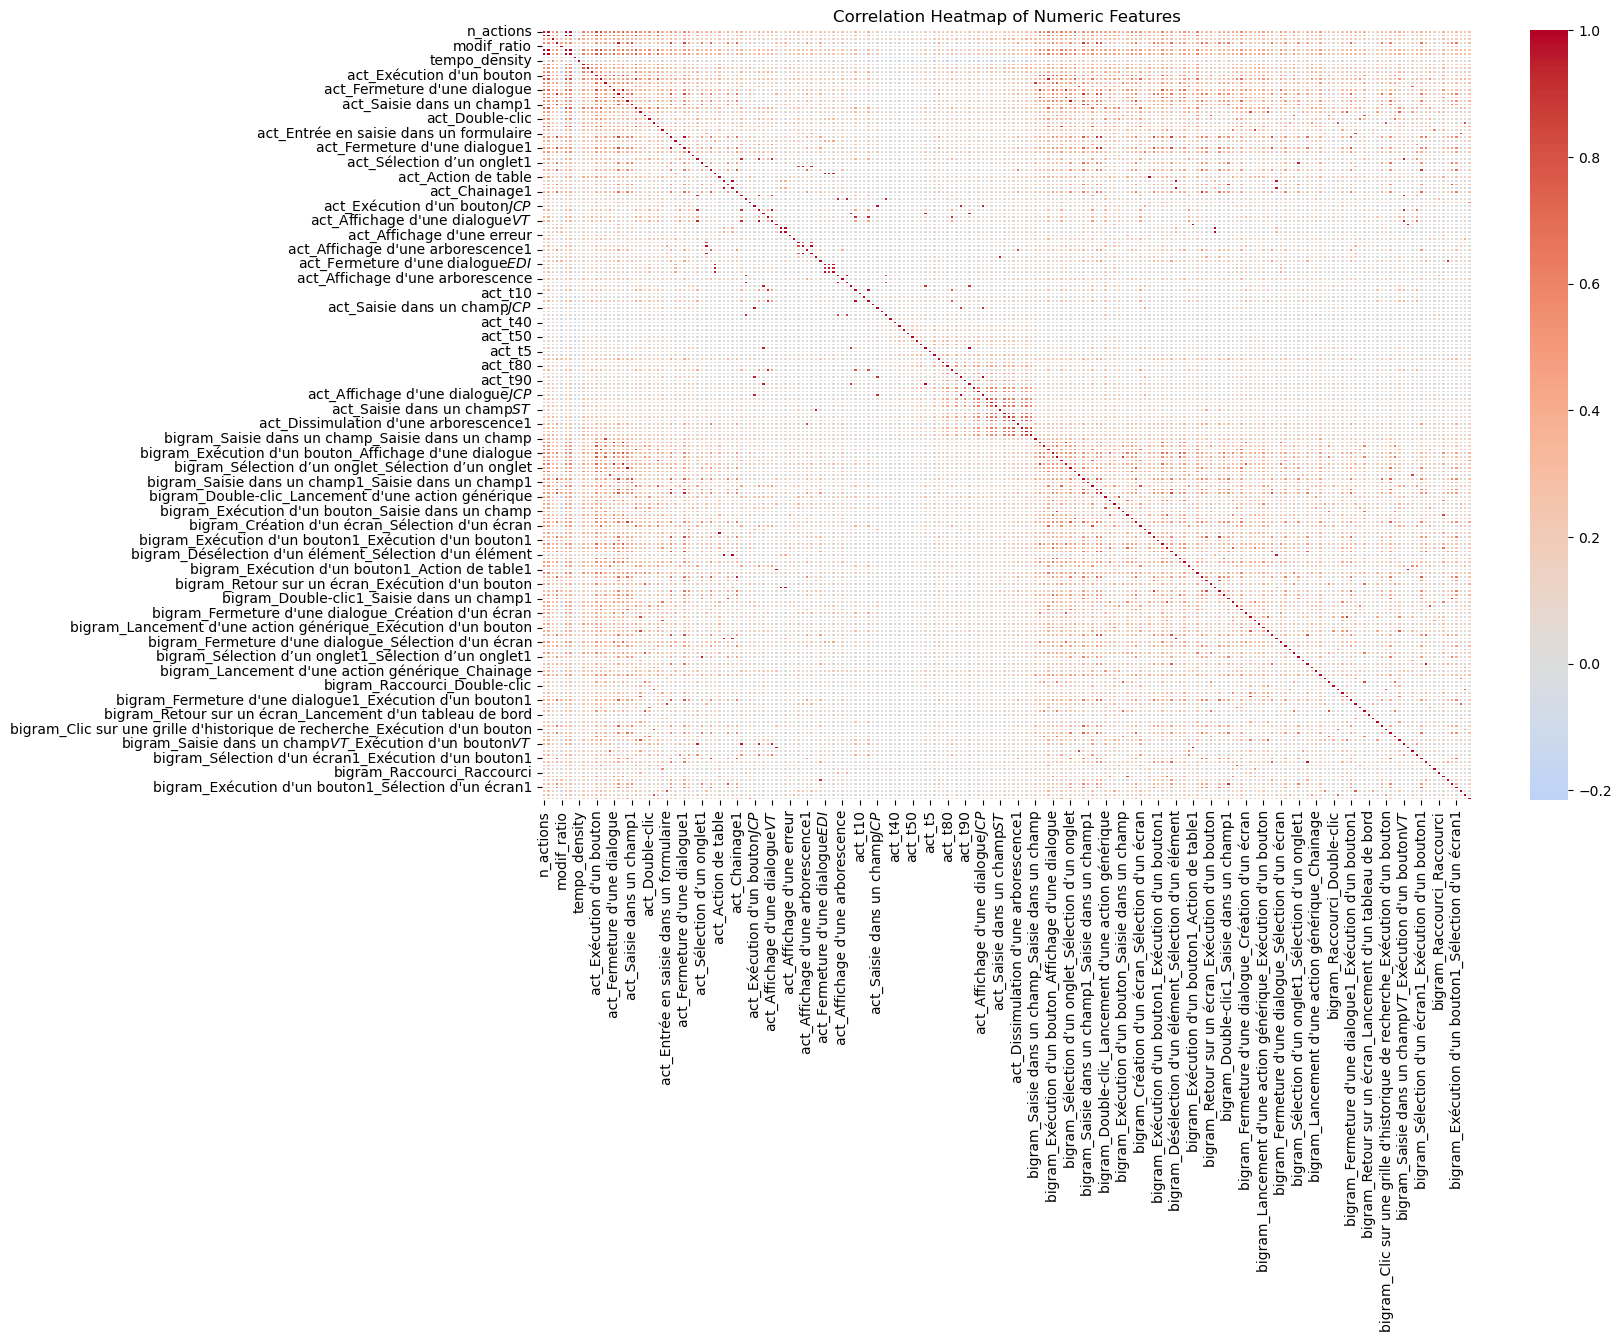

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns


corr = X[num_cols].corr()

plt.figure(figsize=(15, 10))
sns.heatmap(corr, cmap="coolwarm", center=0, linewidths=0.3)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

# Modèle 3: MLP
Pour la construction du modèle à neurones artificiel, on reprend les features trouvées plus tôt et on intègre un tableau de configuration de paramètres afin de les faire varier pour trouver la combinaison de paramètres qui nous fait obtenir le meilleur score. 
En testant différentes fonctions d'activation, c'est avec tanh que nous obtenons les meilleures résultats. On fait varier les paramètres un par un pour fixer une valeur et ensuite tester différentes combinaisons de couches de neurones cachées. 

Dans un second temps on va essayer de tester le réseaux avec connexion récurrente entre les couches. Cette seconde méthode est difficile à tester sur nos machines car une version à performance satisfaisante est assez preneuse en coût. 

In [62]:
# ============================
# CONFIGURATION
# ============================
CONFIG = {
    "hidden_layers": [512, 256, 128, 64],
    "activation": "tanh",
    "dropout_rate": 0.2,
    "epochs": 70,
    "batch_size": 32,
    "optimizer": "adam",
    "loss": "categorical_crossentropy",
    "test_size": 0.1,
    "random_state": 42,
    "top_k_actions": 50,
    "use_browser_ohe": True,
    "train_file": "train.csv",
}

# ============================
# IMPORTS
# ============================
import re, os
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt

# ============================
# UTILITIES
# ============================
def read_ds(ds_name: str):
    sessions = []
    with open(ds_name, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line: 
                continue
            if (line.startswith('"') and line.endswith('"')) or (line.startswith("'") and line.endswith("'")):
                line = line[1:-1]
            parts = line.split(',')
            util = parts[0]
            browser = parts[1] if len(parts) > 1 else ""
            actions = parts[2:]
            sessions.append({"util": util, "browser": browser, "parts": actions})
    return pd.DataFrame(sessions)

def filter_action(value: str):
    if not isinstance(value, str):
        return ""
    if value.startswith("t") and value[1:].isdigit():
        return ""
    for delim in ["(", "<", "$", "1"]:
        if delim in value:
            idx = value.find(delim)
            if idx > 0:
                value = value[:idx]
    return value.strip()

# ============================
# FEATURE ENGINEERING
# ============================
def session_to_features(parts):
    times, actions_clean, timeline = [], [], []
    current_time = 0
    for token in parts:
        tok = token.strip()
        m = re.match(r'^t(\d+)$', tok)
        if m:
            current_time = int(m.group(1))
            continue
        timeline.append((current_time, tok))
        a = filter_action(tok)
        if a:
            actions_clean.append(a)

    if not timeline:
        return {k:0.0 for k in [
            "nb_actions","nb_actions_unique","temps_total","moyenne_delta","std_delta",
            "delta_min","delta_max","delta_median","taux_repetition",
            "longueur_moyenne_sequence","longest_repeat","diversite_actions",
            "top3_ratio","unique_transitions","actions_joined"
        ]}

    times_list = [t for t,_ in timeline]
    deltas = [0.0] + [times_list[i]-times_list[i-1] for i in range(1,len(times_list))]
    nb_actions = len(timeline)
    nb_actions_unique = len(set(actions_clean))
    temps_total = float(times_list[-1]-times_list[0]) if len(times_list)>1 else 0.0
    moyenne_delta = float(np.mean(deltas))
    std_delta = float(np.std(deltas, ddof=1)) if len(deltas)>1 else 0.0
    delta_min = float(np.min(deltas))
    delta_max = float(np.max(deltas))
    delta_median = float(np.median(deltas))

    rep_flags = [1 if actions_clean[i]==actions_clean[i-1] else 0 for i in range(1,len(actions_clean))]
    taux_repetition = float(np.mean(rep_flags)) if rep_flags else 0.0
    seqs, cur = [], 1
    for i in range(1,len(actions_clean)):
        if actions_clean[i]==actions_clean[i-1]: cur+=1
        else: seqs.append(cur); cur=1
    if actions_clean: seqs.append(cur)
    longueur_moy_seq = float(np.mean(seqs)) if seqs else 0.0
    longest_repeat = float(max(seqs)) if seqs else 0.0

    diversite = float(nb_actions_unique/nb_actions) if nb_actions>0 else 0.0
    counts = Counter(actions_clean)
    top3_ratio = sum([counts[a] for a,_ in counts.most_common(3)]) / nb_actions
    bigrams = list(zip(actions_clean[:-1], actions_clean[1:]))
    unique_transitions = len(set(bigrams))

    return {
        "nb_actions": nb_actions,
        "nb_actions_unique": nb_actions_unique,
        "temps_total": temps_total,
        "moyenne_delta": moyenne_delta,
        "std_delta": std_delta,
        "delta_min": delta_min,
        "delta_max": delta_max,
        "delta_median": delta_median,
        "taux_repetition": taux_repetition,
        "longueur_moyenne_sequence": longueur_moy_seq,
        "longest_repeat": longest_repeat,
        "diversite_actions": diversite,
        "top3_ratio": top3_ratio,
        "unique_transitions": unique_transitions,
        "actions_joined": " ".join([a.replace(" ","_") for a in actions_clean])
    }

def build_features_df(df_in):
    rows = []
    for _, row in df_in.iterrows():
        feats = session_to_features(row["parts"])
        feats["browser"] = row["browser"]
        feats["util"] = row["util"]
        rows.append(feats)
    return pd.DataFrame(rows)

# ============================
# MAIN PIPELINE
# ============================
def main_pipeline(config=CONFIG):
    print("Loading data...")
    train_raw = read_ds(config["train_file"])

    print("Building features...")
    train_basic = build_features_df(train_raw)
    train_basic = train_basic[train_basic["nb_actions"]>0].reset_index(drop=True)

    # Action vectorization
    vectorizer = CountVectorizer(max_features=config["top_k_actions"])
    vectorizer.fit(train_basic["actions_joined"].fillna(""))
    X_actions = vectorizer.transform(train_basic["actions_joined"].fillna("")).toarray()

    # Numeric features
    numeric_cols = [
        "nb_actions","nb_actions_unique","temps_total","moyenne_delta","std_delta",
        "delta_min","delta_max","delta_median","taux_repetition",
        "longueur_moyenne_sequence","longest_repeat","diversite_actions",
        "top3_ratio","unique_transitions"
    ]
    scaler = StandardScaler()
    X_num = scaler.fit_transform(train_basic[numeric_cols].fillna(0).values)

    # Browser encoding
    if config["use_browser_ohe"]:
        ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
        X_browser = ohe.fit_transform(train_basic[["browser"]].fillna("UNK"))
    else:
        X_browser = np.zeros((len(train_basic),0))

    # Combine all features
    X_full = np.hstack([X_num, X_browser, X_actions])

    # Labels
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(train_basic["util"].astype(str))
    n_classes = len(label_encoder.classes_)

    # Train / validation split
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_full, y, test_size=config["test_size"],
        random_state=config["random_state"], stratify=y
    )

    # MLP model
    tf.keras.backend.clear_session()
    model = Sequential()
    input_dim = X_tr.shape[1]

    model.add(Dense(config["hidden_layers"][0], activation=config["activation"], input_shape=(input_dim,)))
    model.add(Dropout(config["dropout_rate"]))
    for neurons in config["hidden_layers"][1:]:
        model.add(Dense(neurons, activation=config["activation"]))
        model.add(Dropout(config["dropout_rate"]))
    model.add(Dense(n_classes, activation='softmax'))

    model.compile(optimizer=config["optimizer"], loss=config["loss"])

    # Training with F1 tracking
    f1_tr_list, f1_val_list = [], []
    best_f1_val = -1

    for epoch in range(config["epochs"]):
        model.fit(X_tr, tf.keras.utils.to_categorical(y_tr, n_classes),
                  epochs=1, batch_size=config["batch_size"],
                  validation_data=(X_val, tf.keras.utils.to_categorical(y_val, n_classes)),
                  verbose=0)

        y_pred_tr = np.argmax(model.predict(X_tr, verbose=0), axis=1)
        y_pred_val = np.argmax(model.predict(X_val, verbose=0), axis=1)

        f1_tr = f1_score(y_tr, y_pred_tr, average='macro', zero_division=0)
        f1_val = f1_score(y_val, y_pred_val, average='macro', zero_division=0)

        f1_tr_list.append(f1_tr)
        f1_val_list.append(f1_val)

        print(f"Epoch {epoch+1:02d}/{config['epochs']} — F1 train: {f1_tr:.4f} | F1 val: {f1_val:.4f}")

        if f1_val > best_f1_val:
            best_f1_val = f1_val

    # Plot F1 evolution
    plt.figure(figsize=(8,5))
    plt.plot(f1_tr_list, label="F1 train")
    plt.plot(f1_val_list, label="F1 val")
    plt.xlabel("Epoch")
    plt.ylabel("F1 (macro)")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"\nBest validation F1 (macro): {best_f1_val:.4f}")

# ============================
# RUN
# ============================
if __name__ == "__main__":
    main_pipeline(CONFIG)

: 

### Modèle neuronal à couches récurrentes

In [ ]:
from statistics import mean
from itertools import islice
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


# -----------------------------
# UTIL
# -----------------------------
pattern_ecran = re.compile(r"\((.*?)\)")
pattern_conf = re.compile(r"<(.*?)>")
pattern_chaine = re.compile(r"\$(.*?)\$")

def read_ds(filename: str, has_label: bool = True):
    """Read CSV-like file into DataFrame."""
    if not os.path.exists(filename):
        raise FileNotFoundError(f"{filename} not found")
    rows = []
    with open(filename, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line: continue
            if (line.startswith('"') and line.endswith('"')) or (line.startswith("'") and line.endswith("'")):
                line = line[1:-1]
            parts = line.split(',')
            if has_label:
                util, navigateur, actions = parts[0], parts[1] if len(parts)>1 else "", parts[2:]
            else:
                util, navigateur, actions = None, parts[0] if len(parts)>1 else "", parts[1:] if len(parts)>1 else parts
            rows.append({"util": util, "navigateur": navigateur, "parts": actions})
    return pd.DataFrame(rows)

def filter_action(value: str):
    if not isinstance(value, str): return ""
    if value.startswith("t") and value[1:].isdigit(): return ""
    for delim in ["(", "<", "$", "1"]:
        if delim in value:
            idx = value.find(delim)
            if idx > 0: value = value[:idx]
    return value.strip()

def ngrams(lst, n):
    return zip(*(islice(lst, i, None) for i in range(n)))

def extract_features_from_parts(parts, top_action_set=None, top_bigram_set=None):
    feats = {}
    actions_raw = [p for p in parts if isinstance(p,str)]
    t_marks, actions = [], []
    for a in actions_raw:
        a_strip = a.strip()
        if a_strip.startswith("t") and a_strip[1:].isdigit(): t_marks.append(int(a_strip[1:]))
        else:
            a_clean = filter_action(a_strip)
            if a_clean: actions.append(a_clean)

    feats["n_actions"] = len(actions)
    feats["n_unique_actions"] = len(set(actions))
    feats["repeat_ratio"] = 1.0 - (feats["n_unique_actions"]/feats["n_actions"]) if feats["n_actions"]>0 else 0.0
    feats["n_modif"] = sum(1 for r in actions_raw if isinstance(r,str) and r.strip().endswith("1"))
    feats["modif_ratio"] = feats["n_modif"]/feats["n_actions"] if feats["n_actions"]>0 else 0.0
    feats["t_count"] = len(t_marks)
    feats["max_time"] = max(t_marks) if t_marks else 0
    feats["avg_time_gap"] = mean([j-i for i,j in zip(t_marks[:-1], t_marks[1:])]) if len(t_marks)>1 else 0.0
    feats["tempo_density"] = feats["n_actions"] / (feats["max_time"]+1) if feats["max_time"]>=0 else 0.0

    # action counts
    a_counts = Counter(actions)
    if top_action_set is not None:
        for act in top_action_set: feats[f"act_{act}"] = a_counts.get(act,0)
    else:
        for act,cnt in a_counts.items(): feats[f"act_{act}"] = cnt

    # bigram counts
    bigrams = ["_".join(bg) for bg in ngrams(actions, 2)]
    b_counts = Counter(bigrams)
    if top_bigram_set is not None:
        for bg in top_bigram_set: feats[f"bigram_{bg}"] = b_counts.get(bg,0)
    else:
        for bg,cnt in b_counts.items(): feats[f"bigram_{bg}"] = cnt

    # longest consecutive repeat
    longest_repeat = 0
    if actions:
        cur = 1
        for i in range(1, len(actions)):
            if actions[i]==actions[i-1]: cur+=1
            else: longest_repeat=max(longest_repeat,cur); cur=1
        longest_repeat=max(longest_repeat,cur)
    feats["longest_repeat"] = longest_repeat

    feats["unique_transitions"] = len(set(bigrams))
    feats["actions_joined"] = " ".join([a.replace(" ", "_") for a in actions])
    return feats

# -----------------------------
# MAIN PIPELINE
# -----------------------------
def main_lstm_f1(config):
    train_raw = read_ds(config["train_file"], has_label=True)
    test_raw  = read_ds(config["test_file"],  has_label=False)

    # compute top actions/bigrams
    all_actions, all_bigrams = [], []
    for _, r in train_raw.iterrows():
        parts = [p for p in r["parts"] if isinstance(p,str)]
        actions = [filter_action(p.strip()) for p in parts if not (p.strip().startswith("t") and p.strip()[1:].isdigit()) and filter_action(p.strip())]
        all_actions.extend(actions)
        all_bigrams.extend(["_".join(bg) for bg in ngrams(actions, 2)])
    top_actions = [a for a,_ in Counter(all_actions).most_common(config["top_k_actions"])]
    top_bigrams = [b for b,_ in Counter(all_bigrams).most_common(config["top_k_bigrams"])]
    top_action_set, top_bigram_set = set(top_actions), set(top_bigrams)

    # extract tabular features
    df_train_feats = pd.DataFrame([extract_features_from_parts(r["parts"], top_action_set, top_bigram_set) | {"navigateur": r["navigateur"], "util": r["util"]} for _, r in train_raw.iterrows()]).fillna(0)
    df_test_feats  = pd.DataFrame([extract_features_from_parts(r["parts"], top_action_set, top_bigram_set) | {"navigateur": r["navigateur"]} for _, r in test_raw.iterrows()]).fillna(0)

    # tokenizer
    tokenizer = Tokenizer(oov_token="<UNK>")
    tokenizer.fit_on_texts(df_train_feats["actions_joined"].tolist())
    vocab_size = len(tokenizer.word_index)+1
    X_seq_train = pad_sequences(tokenizer.texts_to_sequences(df_train_feats["actions_joined"].tolist()), maxlen=500, padding='post')
    X_seq_test  = pad_sequences(tokenizer.texts_to_sequences(df_test_feats["actions_joined"].tolist()), maxlen=500, padding='post')

    # numeric tabular
    exclude_cols = {"actions_joined","util","navigateur"}
    numeric_cols = [c for c in df_train_feats.columns if c not in exclude_cols and df_train_feats[c].dtype in [np.float64,np.int64,np.int32,np.float32,np.int16]]
    scaler = StandardScaler()
    X_tab_train = scaler.fit_transform(df_train_feats[numeric_cols].values)
    X_tab_test  = scaler.transform(df_test_feats[numeric_cols].values)

    # browser encoding
    try:
        ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
    except TypeError:
        ohe = OneHotEncoder(sparse=False, handle_unknown="ignore")
    ohe.fit(df_train_feats[["navigateur"]].fillna("UNK"))
    X_nav_train = ohe.transform(df_train_feats[["navigateur"]].fillna("UNK"))
    X_nav_test  = ohe.transform(df_test_feats[["navigateur"]].fillna("UNK"))

    X_tab_train_full = np.hstack([X_tab_train, X_nav_train])
    X_tab_test_full  = np.hstack([X_tab_test, X_nav_test])

    # labels
    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(df_train_feats["util"].astype(str))
    n_classes = len(label_encoder.classes_)

    # train/val split
    X_seq_tr, X_seq_val, X_tab_tr, X_tab_val, y_tr, y_val = train_test_split(
        X_seq_train, X_tab_train_full, y_train,
        test_size=config["test_size"], stratify=y_train, random_state=config["random_state"]
    )

    # build model
    tf.keras.backend.clear_session()
    seq_input = Input(shape=(X_seq_tr.shape[1],))
    x_seq = Embedding(vocab_size, config["embedding_dim"])(seq_input)
    x_seq = LSTM(config["lstm_units"])(x_seq)
    x_seq = Dropout(config["dropout_rate"])(x_seq)
    tab_input = Input(shape=(X_tab_tr.shape[1],))
    x_tab = Dense(config["dense_units_tabular"][0], activation="relu")(tab_input)
    x_tab = Dropout(config["dropout_rate"])(x_tab)
    x = Concatenate()([x_seq, x_tab])
    for units in config["dense_units_after_concat"]:
        x = Dense(units, activation="tanh")(x)
        x = Dropout(config["dropout_rate"])(x)
    out = Dense(n_classes, activation="softmax")(x)
    model = Model([seq_input, tab_input], out)
    model.compile(optimizer=config["optimizer"], loss=config["loss"])

    # training + F1 tracking
    f1_tr_list, f1_val_list = [], []
    best_f1_val = 0.0
    for epoch in range(config["epochs"]):
        model.fit([X_seq_tr, X_tab_tr], tf.keras.utils.to_categorical(y_tr, n_classes),
                  validation_data=([X_seq_val, X_tab_val], tf.keras.utils.to_categorical(y_val, n_classes)),
                  epochs=1, batch_size=config["batch_size"], verbose=0)
        y_pred_val = np.argmax(model.predict([X_seq_val, X_tab_val], verbose=0), axis=1)
        y_pred_tr  = np.argmax(model.predict([X_seq_tr, X_tab_tr], verbose=0), axis=1)
        f1_val = f1_score(y_val, y_pred_val, average='macro', zero_division=0)
        f1_tr  = f1_score(y_tr, y_pred_tr, average='macro', zero_division=0)
        f1_tr_list.append(f1_tr)
        f1_val_list.append(f1_val)
        if f1_val > best_f1_val: best_f1_val = f1_val
        print(f"Epoch {epoch+1}/{config['epochs']} — F1 train: {f1_tr:.4f} | F1 val: {f1_val:.4f}")

    # plot
    plt.figure(figsize=(8,5))
    plt.plot(range(1, config["epochs"]+1), f1_tr_list, label="F1 train")
    plt.plot(range(1, config["epochs"]+1), f1_val_list, label="F1 val")
    plt.xlabel("Epoch"); plt.ylabel("F1 (macro)"); plt.grid(True); plt.legend(); plt.show()

    print(f"Best validation F1: {best_f1_val:.4f}")
    return f1_tr_list, f1_val_list, best_f1_val

# -----------------------------
# RUN
# -----------------------------
CONFIG = {
    "embedding_dim": 64, "lstm_units": 128, "dense_units_after_concat":[256,128,64],
    "dense_units_tabular":[128], "dropout_rate":0.3,
    "epochs":30, "batch_size":64, "optimizer":"adam", "loss":"categorical_crossentropy",
    "test_size":0.1, "random_state":42,
    "top_k_actions":200, "top_k_bigrams":200,
    "train_file":"train.csv", "test_file":"test.csv"
}

if __name__ == "__main__":
    f1_tr, f1_val, best_f1 = main_lstm_f1(CONFIG)

### Comparaison entre MLP classique et pipeline LSTM + features tabulaires

Ce pipeline LSTM est une évolution des modèles neuronaux classiques pour la prédiction d'utilisateur à partir de sessions. Voici les différences principales avec le modèle MLP :

1. **Prise en compte de la séquence temporelle**
   - **MLP classique** : les actions sont simplement vectorisées (par CountVectorizer) et traitées comme un ensemble de features indépendantes.  
     - Les informations sur l’ordre des actions sont perdues.  
     - Les bigrams ou séquences sont parfois ajoutés comme features, mais de manière statique.
   - **Pipeline LSTM** : chaque session est convertie en séquence d’actions, puis transformée via un **Embedding** et un **LSTM**.  
     - Le LSTM capture les dépendances temporelles et les motifs séquentiels, par exemple des répétitions d’actions ou des transitions fréquentes.  
     - Le modèle apprend automatiquement quels motifs dans la séquence sont importants pour prédire l’utilisateur.

2. **Combinaison de données séquentielles et tabulaires**
   - **MLP classique** : toutes les features (numeriques + vecteurs d’actions) sont concaténées en un seul vecteur d’entrée.  
   - **Pipeline LSTM** : le modèle a **deux branches** distinctes :  
     1. Une branche séquence pour les LSTM/embeddings.  
     2. Une branche tabulaire pour les statistiques extraites (nombre d’actions, bigrams, répétitions, densité temporelle, navigateur).  
     - Ces deux représentations sont **concaténées** ensuite et passées dans des couches denses.  
     - Cela permet au modèle de combiner à la fois les patterns temporels et les résumés tabulaires, ce que le MLP classique ne peut pas faire directement.

3. **Feature engineering ciblé pour les séquences**
   - **MLP classique** : les features sont principalement des statistiques globales de la session (nombre d’actions, durée, répétitions, top-k actions).  
   - **Pipeline LSTM** : en plus de ces statistiques, le LSTM apprend des représentations dynamiques de la séquence.  
     - Les bigrams sont utilisés comme features tabulaires, mais le LSTM peut détecter des motifs plus complexes, comme des patterns de transition sur plusieurs actions.  
     - Les embeddings permettent également de capturer des similarités entre actions qui ne sont pas évidentes dans un MLP classique.

En résumé, le pipeline LSTM + tabulaire améliore le MLP classique en ajoutant :  
- Une compréhension de la **chronologie et des motifs séquentiels**,  
- Une **fusion intelligente** des informations séquentielles et tabulaires,  
- Une capacité à apprendre automatiquement des représentations pertinentes des actions au lieu de dépendre uniquement de features statistiques fixes.


### Conclusion

Ainsi, en ayant vu ces différentes méthodes nous sommes finalement arrivés à un résultat qui favorisait le choix d'un random forest pour le meilleur modèle possible sur ce type de données. Cela fait sens avec le fait que les données contiennent un large pannel de features qui sont mises en valeur dans la réalisation d'arbres de décisions. 
